### Importing Libraries

In [1]:
import pandas as pd
import osmnx
import geopandas
from splot.esda import plot_moran
import libpysal.weights as weights
import seaborn
import contextily as cx
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import functions

### Datasets Path

In [ ]:
crash_data = pd.read_csv("./Raw_Dataset/Dataset.csv")
crash_data_for_regression = pd.read_csv("./Raw_Dataset/New_Dataset.csv")
weather_data = pd.read_csv("./Raw_Dataset/weather.csv")

# 1.Data Preprocessing

### Removing Unnecessary columns

In [ ]:
crash_data = functions.drop_columns(crash_data)

### Handle Missing Values

In [ ]:
crash_data = crash_data.dropna(subset=['LATITUDE', 'LONGITUDE'])
crash_data_for_regression = functions.drop_missing_data(crash_data_for_regression)
crash_data_for_regression = functions.fill_missing_data(crash_data_for_regression)

/home/amin/Documents/Uni/Spatial Data/Project/functions.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda s: s.lower() if type(s) == str else s)
/home/amin/Documents/Uni/Spatial Data/Project/functions.py:29: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.Weather_Timestamp.interpolate(method='ffill', inplace=True)


### Filter Dataset from 2016 to 2022

In [ ]:
crash_data_for_regression = functions.divide_timestamps(crash_data_for_regression)
crash_data_for_regression = crash_data_for_regression[(crash_data_for_regression['Start_Time_Year'] >= '2016') & (crash_data_for_regression['Start_Time_Year'] <= '2022')]
crash_data =  crash_data[crash_data["CRASH DATE"].str.contains("2016|2017|2018|2019|2020|2021|2022")]
crash_data = functions.correct_timestamps(crash_data)


/home/amin/Documents/Uni/Spatial Data/Project/functions.py:160: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crash_data_gdf["CRASH TIME"] = pd.to_datetime(crash_data_gdf["CRASH TIME"])


### Creating GeoDataFrame


In [ ]:
crash_points = geopandas.points_from_xy(
    x=crash_data["LONGITUDE"],
    y=crash_data["LATITUDE"],
    crs="EPSG:4326",
)

crash_points_for_regression = geopandas.points_from_xy(
    x=crash_data_for_regression["Start_Lng"],
    y=crash_data_for_regression["Start_Lat"],
    crs="EPSG:4326",
)

crash_data_gdf = geopandas.GeoDataFrame(crash_data, geometry=crash_points)
crash_data_for_regression_gdf = geopandas.GeoDataFrame(crash_data_for_regression, geometry=crash_points_for_regression)

### Removing outliers (Points not in bounding box of New York City)

In [ ]:
crash_data_for_regression_gdf = crash_data_for_regression_gdf[crash_data_for_regression_gdf['State'] == 'ny']
crash_data_for_regression_gdf = functions.points_in_NY(crash_data_for_regression_gdf)
crash_data_gdf = functions.points_in_NY(crash_data_gdf)

### Saving Dataset

In [ ]:
# Save dataset in csv

crash_data_gdf.to_csv("./Dataset/Crash_Data.csv", index=False)
crash_data_for_regression_gdf.to_csv("./Dataset/Crash_Data_For_Regression.csv", index=False)
weather_data.to_csv("./Dataset/Weather_Data.csv", index=False)

# 2. Exploratory Data Analysis 
### !!-- Run from here if preprocessed dataset --!!

### Loading preprocessed data

In [2]:
crash_data = pd.read_csv("./Dataset/Crash_Data.csv")
crash_data_for_regression = pd.read_csv("./Dataset/Crash_Data_For_Regression.csv")
weather_data = pd.read_csv("./Dataset/Weather_Data.csv")

crash_points = geopandas.points_from_xy(
    x=crash_data["LONGITUDE"],
    y=crash_data["LATITUDE"],
    crs="EPSG:4326",
)

crash_points_for_regression = geopandas.points_from_xy(
    x=crash_data_for_regression["Start_Lng"],
    y=crash_data_for_regression["Start_Lat"],
    crs="EPSG:4326",
)

crash_data_gdf = geopandas.GeoDataFrame(crash_data, geometry=crash_points)
crash_data_for_regression_gdf = geopandas.GeoDataFrame(crash_data_for_regression, geometry=crash_points_for_regression)

### Traffic Crashes by year, month, hour

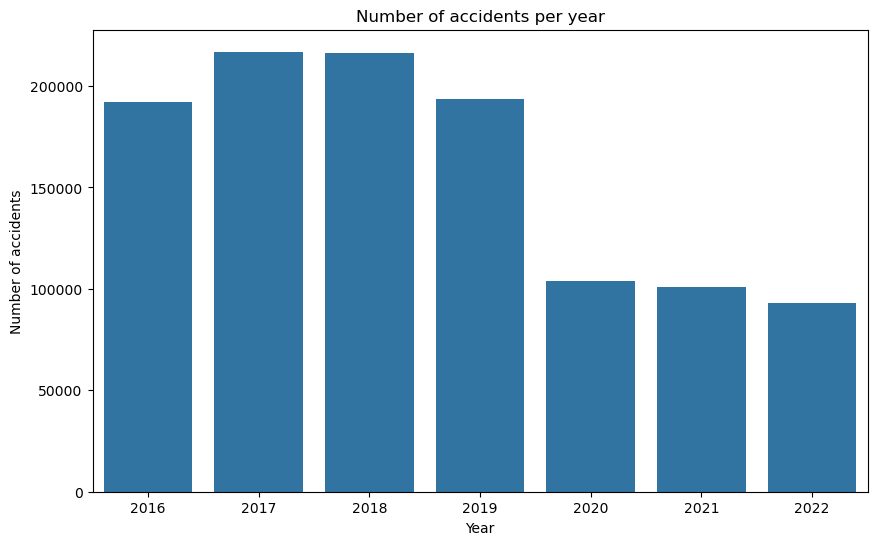

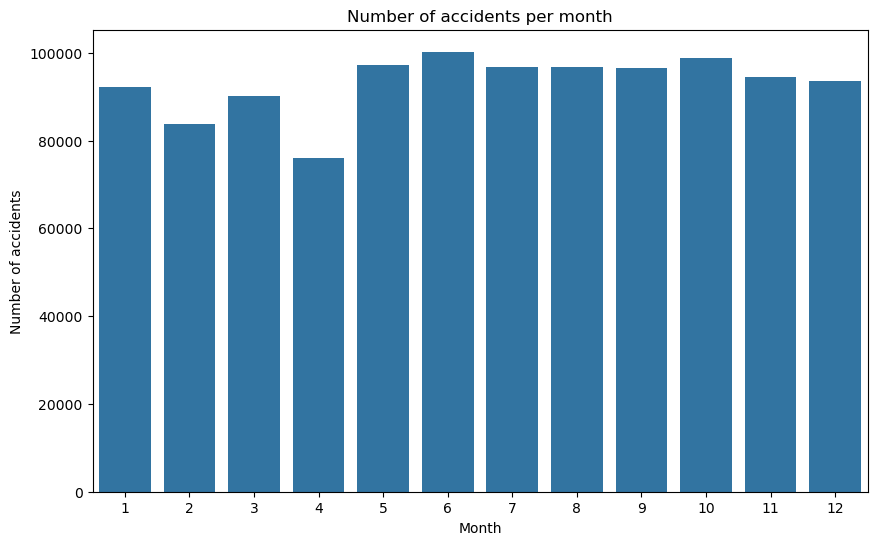

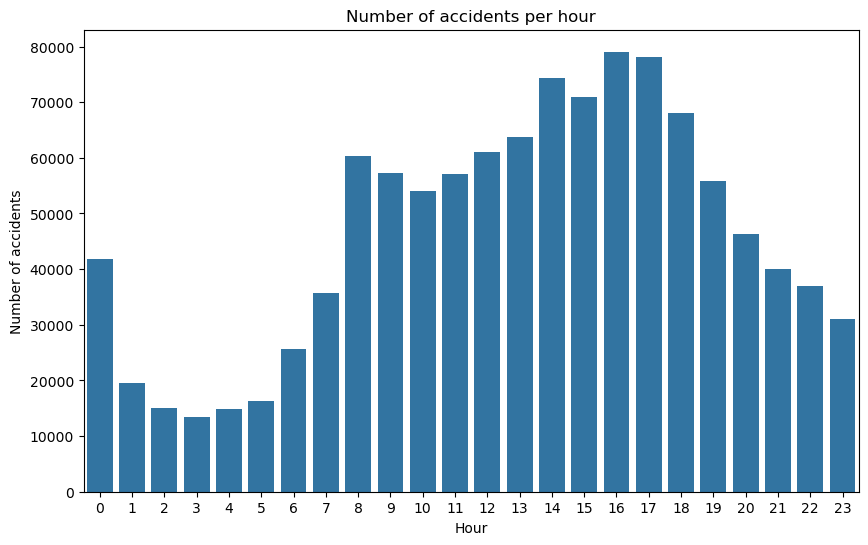

In [3]:
functions.temporal_analysis(crash_data_gdf)

Analysis: The data illustrates a concerning trend in traffic crashes from 2016 to 2019, with numbers steadily increasing. However, a notable deviation occurred in subsequent years, showing a sharp decline. This abrupt change may be attributed to the impact of the COVID-19 pandemic and the subsequent lockdown measures implemented in New York City.

Furthermore, an examination of the timing of these incidents reveals a distinct pattern. The majority of traffic crashes tend to occur during the morning and late afternoon hours, spanning from 8:00 AM to 5:00 PM. This correlation can likely be attributed to the typical working hours of individuals, suggesting a connection between commuting times and the frequency of accidents


### Most Common Contributing Factors

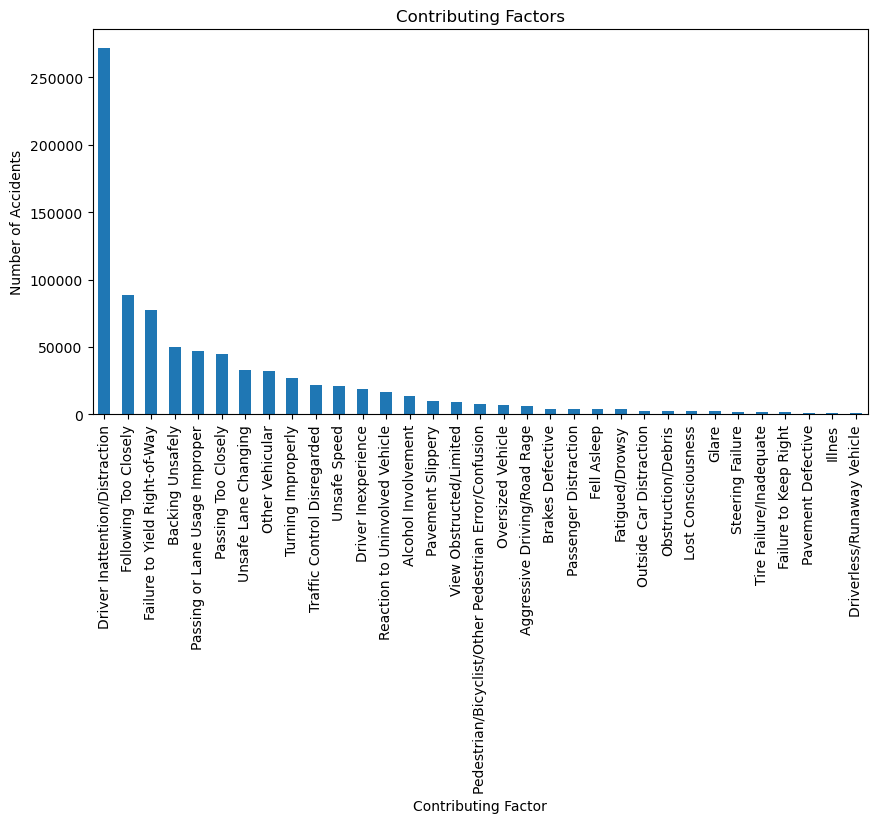

In [4]:
functions.contributing_factors_plot(crash_data_gdf)

Analysis: It is observed that the majority of traffic accidents in NYC are primarily caused by driver inattention or distraction. Other Contributing factors are also observed from the figure above

# 3. Point-Pattern Analysis

### Visualizing with Jointplot

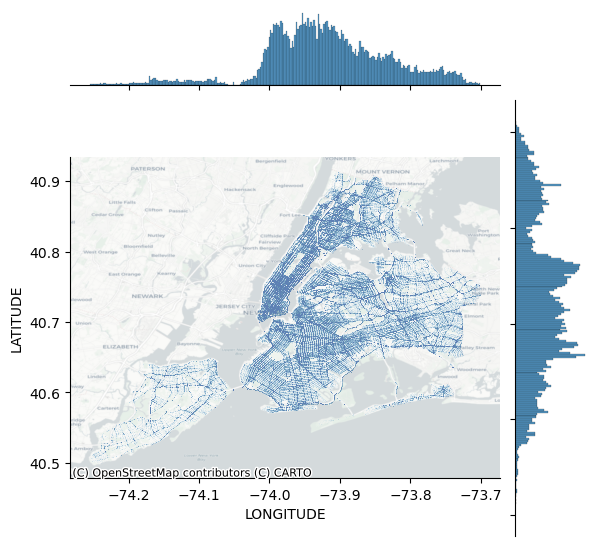

In [5]:
seaborn.jointplot(x="LONGITUDE", y="LATITUDE", data=crash_data_gdf, s=0.01)
cx.add_basemap(plt.gca(), crs=crash_data_gdf.crs,source=cx.providers.CartoDB.Positron)

Analysis: The data points are widely dispersed, reflecting the inherent variability of the dataset. However, there is a noticeable concentration of incidents in the Manhattan area. Further analysis is required to identify specific hotspots within this region

### Hexbinning


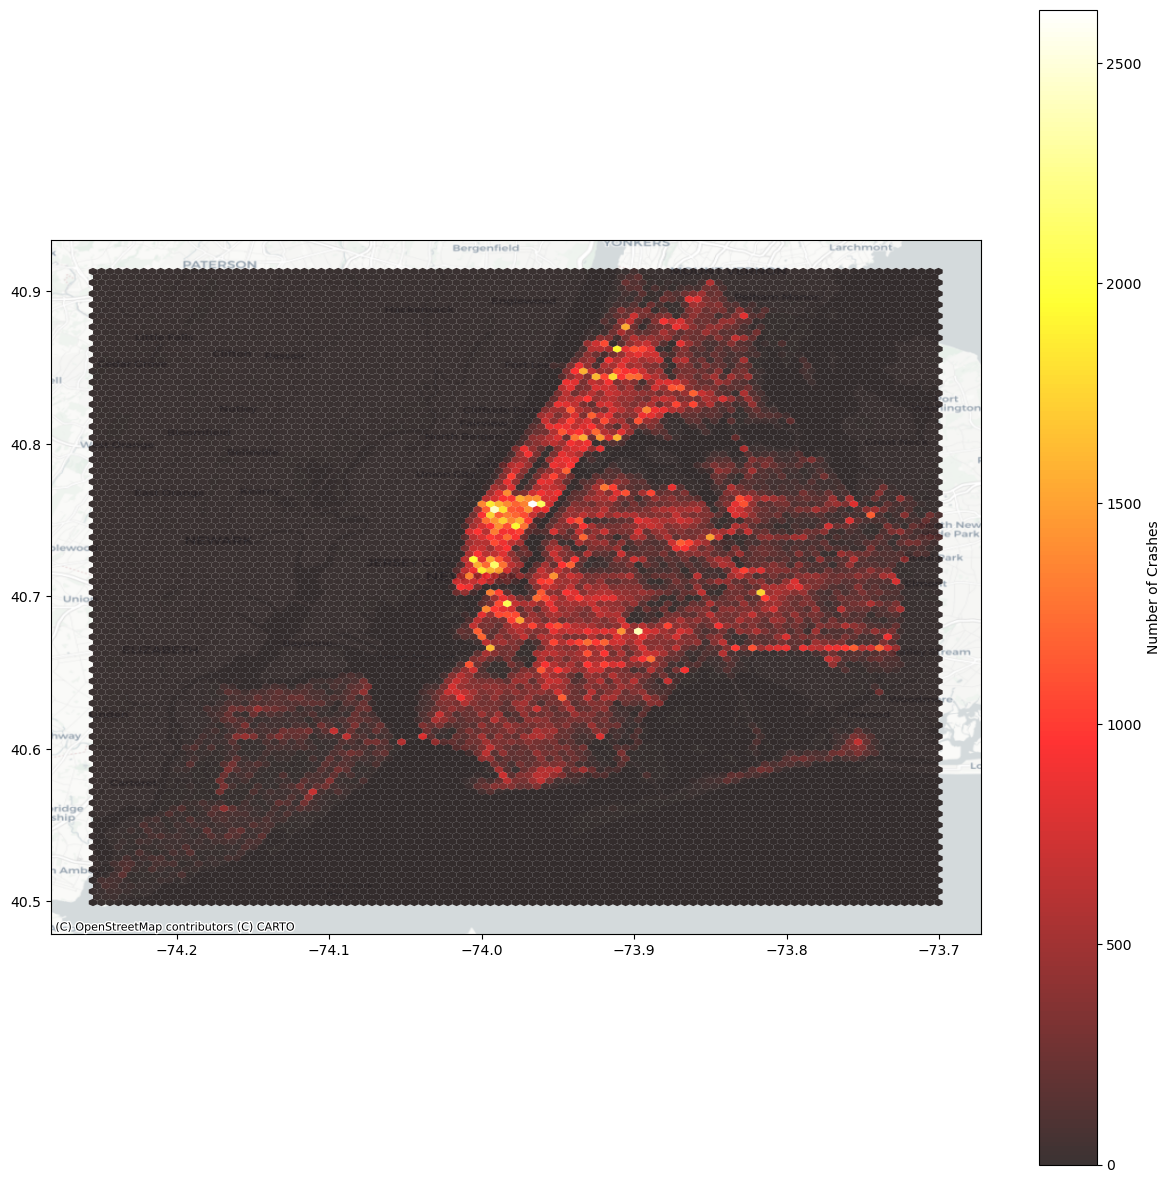

In [6]:
functions.hexbinning(crash_data_gdf, crash_data_gdf.crs)

Hex-binning is employed to identify and visualize hotspots in the data. Areas with a high concentration of traffic crashes are highlighted in bright colors, while regions with fewer crashes appear in darker colors. This method effectively illustrates the density of incidents and helps pinpoint areas with significant traffic safety concerns.

### KDE-Plot

In [7]:
functions.kdeplot(crash_data_gdf)

/home/amin/Documents/Uni/6th sem/Spatial Data/Project/BSCS21049_SATANYCIHCF_FMS/functions.py:269: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


# 4. Spatial Autocorrelation Analaysis

### Grid Creation to combine accidents

In [ ]:
grid = functions.make_grid(crash_data_gdf, 0.005)
grid = grid[grid.within(osmnx.geocode_to_gdf("New York City, New York, USA").geometry.unary_union)]
grid = grid[grid["crash_count"] > 0]

ConnectionError: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?format=json&polygon_geojson=1&dedupe=0&limit=50&q=New+York+City%2C+New+York%2C+USA (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f8fc63b33d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

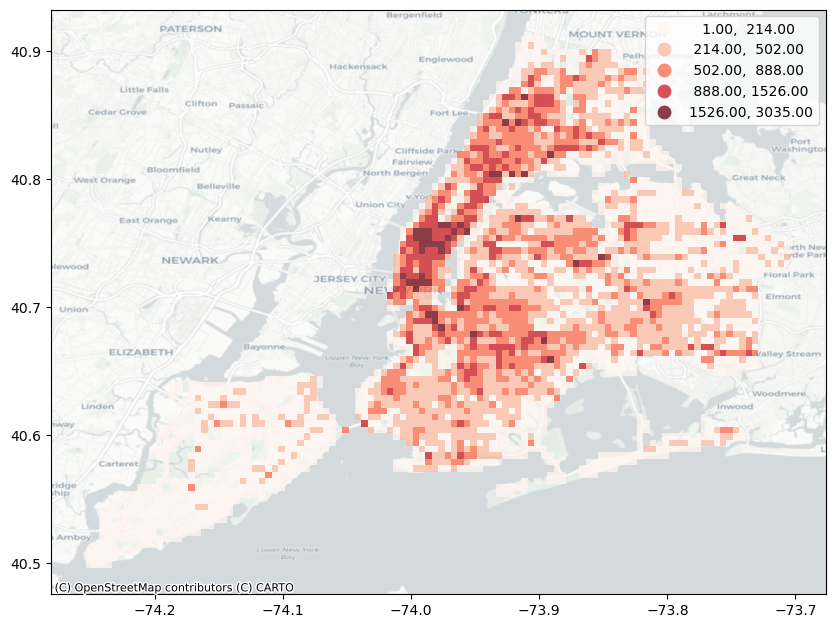

In [ ]:
functions.plot_grid(grid,crs = crash_data_gdf.crs)

The data points are divided into a grid with each cell measuring 0.005 degrees of longitude by 0.005 degrees of latitude. The Fisher-Jenks method is then utilized to classify these areas based on increasing crash counts, allowing for a clear identification of regions with varying levels of traffic incidents.

### Assigning weights and calculating spatial lag

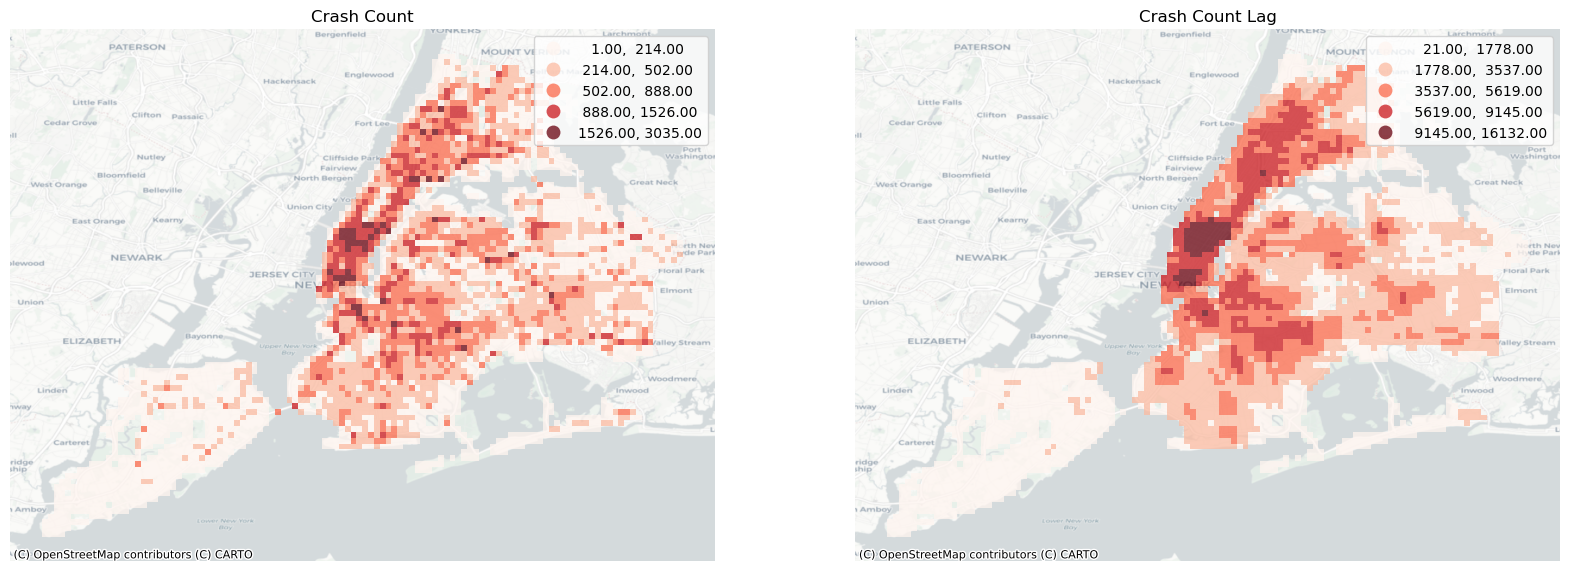

In [ ]:
w = weights.KNN.from_dataframe(grid, k=8)
grid["crash_count_lag"] = weights.spatial_lag.lag_spatial(w, grid["crash_count"])
functions.plot_lag(grid,crs = crash_data_gdf.crs)    

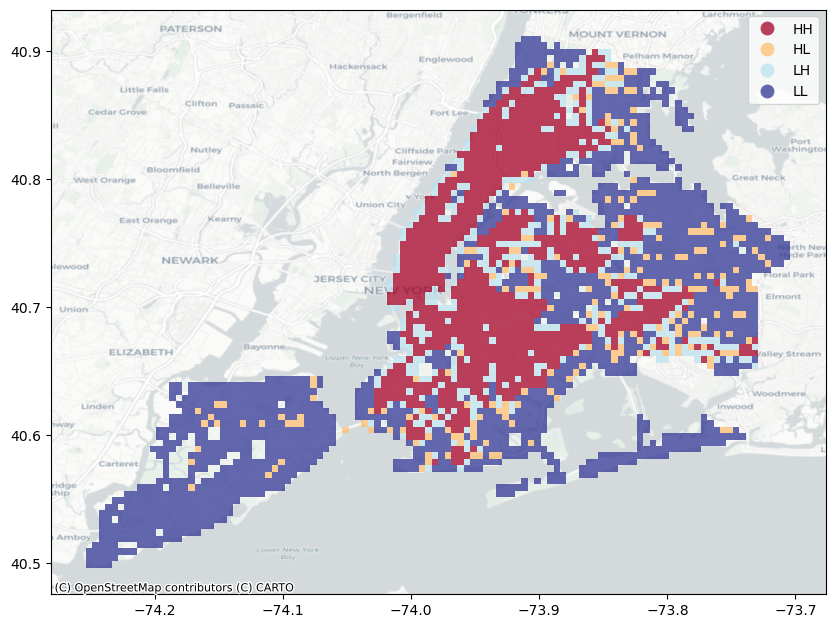

In [ ]:
functions.plot_HH_LL(grid,crs= crash_data_gdf.crs)

Analysis: It can be observed that areas with higher crash counts are typically surrounded by other high-value areas, while areas with lower crash counts are generally surrounded by other low-value areas. To gain a clearer understanding of this spatial autocorrelation, we will calculate Moran's I. This statistical measure will help quantify the degree of clustering of similar values, providing further insight into the spatial patterns of traffic crashes.

### Moran's I and Global Spatial Autocorrelation

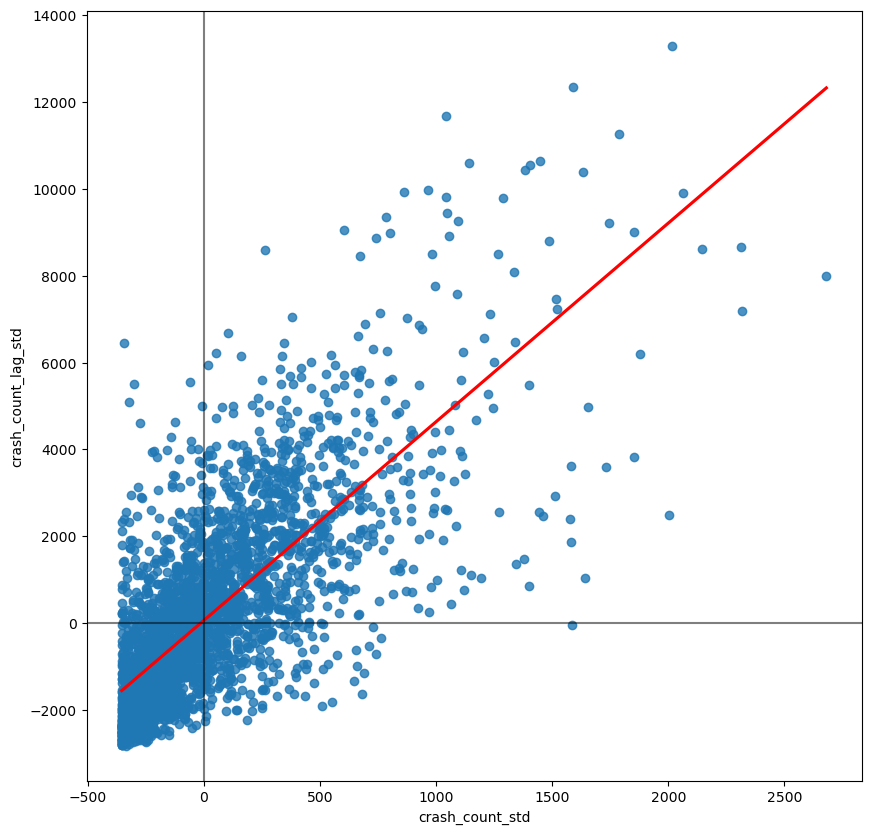

Moran's I:  0.5714528540666635


In [ ]:
moran = functions.moran_scatter(grid,w)

Analysis: The calculated value of Moran's I is 0.5714528540666635. This indicates a significant positive spatial autocorrelation, meaning that traffic crash counts are not randomly distributed across the area. Instead, high crash count areas are clustered together, as are low crash count areas. This confirms the observation that regions with similar crash counts tend to be geographically proximate.

/home/amin/miniconda3/envs/test/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.57', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.57)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

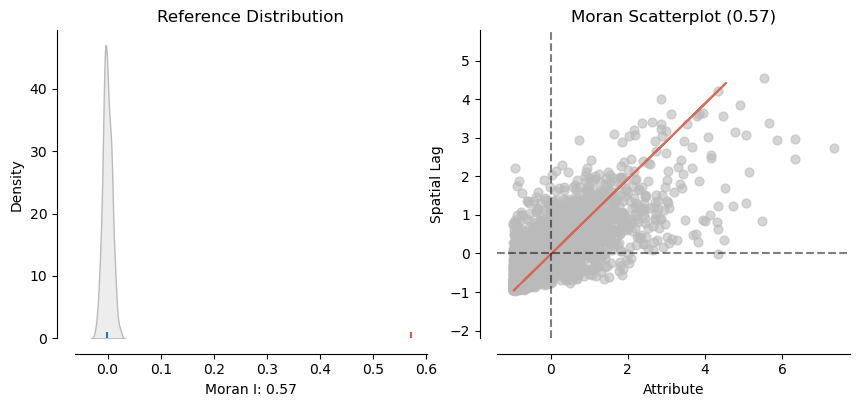

In [ ]:
plot_moran(moran)

# 5. Weather Analysis

### Effect of Rain on Traffic Crashes

In [ ]:
total_accidents, total_rainy_hours, total_non_rainy_hours, total_rainy_accidents, total_non_rainy_accidents, accident_rate_rainy, accident_rate_non_rainy,rainy_df, non_rainy_df = functions.calculate_accident_rates(weather_data,crash_data_gdf)

print("Total accidents: ", total_accidents)
print("Total rainy hours: ", total_rainy_hours)
print("Total non-rainy hours: ", total_non_rainy_hours)
print("Total rainy accidents: ", total_rainy_accidents)
print("Total non-rainy accidents: ", total_non_rainy_accidents)
print("Accident rate on rainy hours: ", accident_rate_rainy)
print("Accident rate on non-rainy hours: ", accident_rate_non_rainy)

Total accidents:  1099915
Total rainy hours:  8622
Total non-rainy hours:  50970
Total rainy accidents:  163727
Total non-rainy accidents:  934343
Accident rate on rainy hours:  18.989445604268152
Accident rate on non-rainy hours:  18.33123405925054


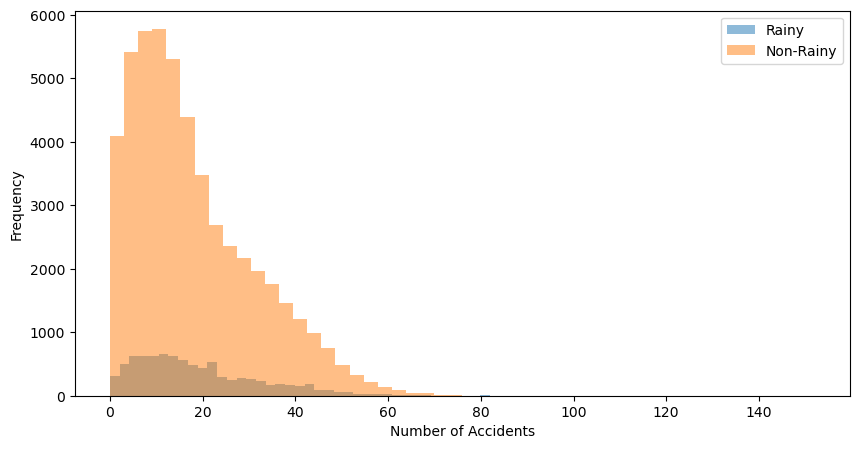

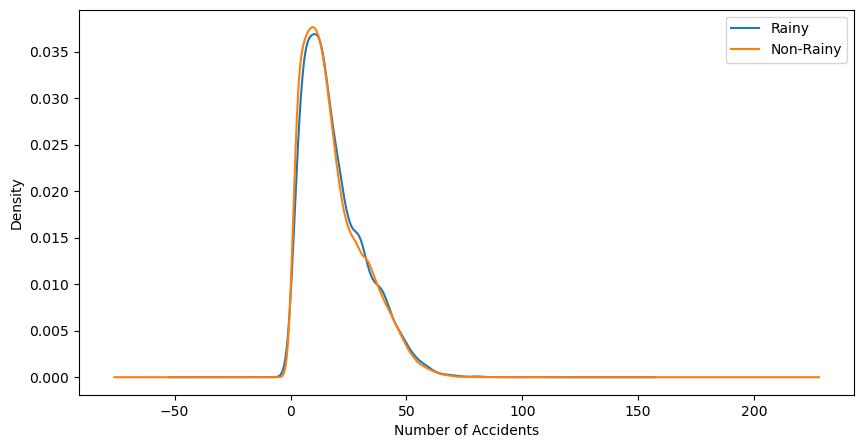

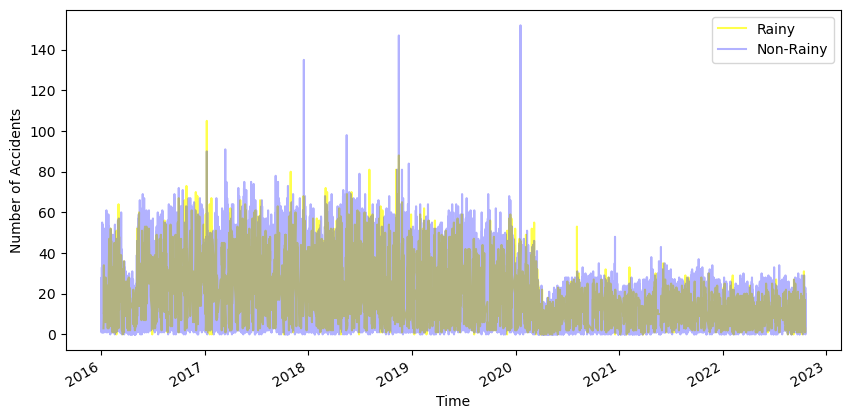

In [ ]:
functions.plot_rainy_nonrainy_pdfs(rainy_df, non_rainy_df)

The dataset reveals that 14.47% of the total hours are rainy, during which 14.89% of the total accidents occur. In comparison, 85.53% of the hours are non-rainy, corresponding to 84.95% of the total accidents. Despite a slightly higher accident rate during rainy hours, the increase in accident rate is only around <b>3.6%</b>. This minor increase suggests that the impact of rainy conditions on accident rates is statistically insignificant. The probability density functions (PDFs) for accidents in both conditions are essentially the same which can be observed from the figures above. Therefore, we can accept the null hypothesis, which states that there is no significant difference in accident rates between rainy and non-rainy conditions.

# 6. Alcohol Involvement Analysis

### Effect of Alcohol Involvement on Weekdays vs Weekends

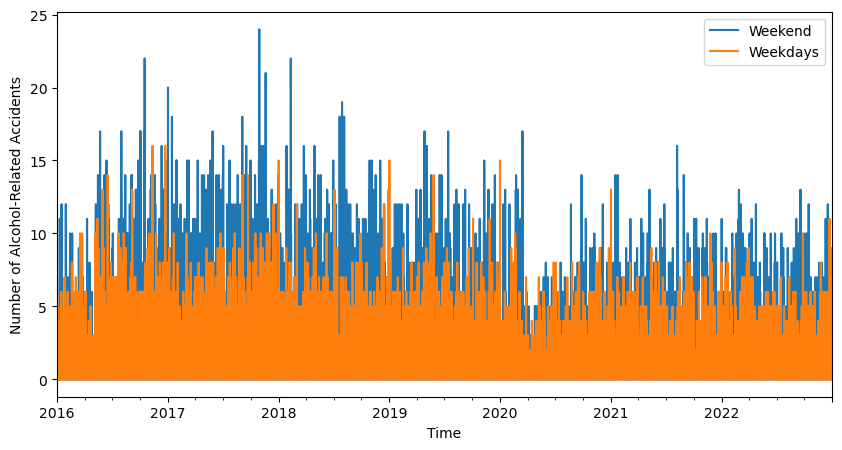

Weekend alcohol accidents:  6326
Weekdays alcohol accidents:  7103


In [ ]:
weekend_alcohol_count, weekdays_alcohol_count = functions.alcohol_analysis(crash_data_gdf)

print("Weekend alcohol accidents: ", weekend_alcohol_count)
print("Weekdays alcohol accidents: ", weekdays_alcohol_count)

Analysis: For weekends, the total of 6,326 accidents over 2 days results in an average of 3,163 accidents per day. In contrast, the 7,103 weekday accidents spread over 5 days yield an average of 1,420.6 accidents per day. This calculation reveals a significant difference in the average daily occurrence of alcohol-related accidents between weekends and weekdays.

The average number of alcohol-related accidents per day on weekends is approximately <b>122.6%</b> higher than on weekdays. Thus, we will reject the null hypothesis. It proves that alcohol related accidents happen more often on Weekends

# 7. Hotspot Analysis

### Finding Contributing Factors in Hotspots

In [ ]:
top_grid = functions.find_factos(grid,30)
functions.plot_top_grid(top_grid)

/home/amin/miniconda3/envs/test/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/amin/miniconda3/envs/test/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


The primary objective of this study is to identify hotspots of traffic crashes and the factors contributing to these incidents. Utilizing the Folium map, we visualize each grid cell, highlighting the most common contributing factor, street name, and crash count. The severity of crash counts is color-coded, with red indicating the highest number of crashes, followed by orange and yellow for lower counts.

The analysis reveals that the majority of hotspots are located on key roads throughout New York City. In particular, Manhattan stands out with a high concentration of hotspots, notably from 2nd Avenue to 10th Avenue. Across all analyzed areas, "Driver Inattention/Distraction" emerges as the most prevalent contributing factor to these accidents.

# 8. Spatial Regression

The goal of spatial regression is to accurately predict severity of traffic accidents based on several variables. We select the following set of variables for this analysis

In [ ]:
variable_names = [
    "Severity",
    "Start_Lat",
    "Start_Lng",
    "Distance(mi)",
    "Temperature(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Speed(mph)",
    "Precipitation(in)",
    "Crossing",
    "Junction",
    "Traffic_Signal",
    "Station",
    "Give_Way",
    "Railway",
    "Bump",
    "No_Exit",
    "Traffic_Calming",
    "Amenity"
]

### Encoding categorical variables

In [ ]:
data = crash_data_for_regression_gdf[variable_names].replace([True, False], [1,0])

data = functions.onehot_encode(
    data,
    columns=["Crossing",
    "Junction",
    "Traffic_Signal",
    "Station",
    "Give_Way",
    "Railway",
    "Bump",
    "No_Exit",
    "Traffic_Calming",
    "Amenity"],
    prefixes=["Crossing",
    "Junction",
    "Traffic_Signal",
    "Station",
    "Give_Way",
    "Railway",
    "Bump",
    "No_Exit",
    "Traffic_Calming",
    "Amenity"]
)


In [ ]:
data = data.rename(columns={'Distance(mi)': 'Distance_mi', 'Humidity(%)': 'Humidity_perc', 'Pressure(in)': 'Pressure_in','Precipitation(in)':'Precipitation_in', 'Wind_Speed(mph)': 'Wind_Speed_mph','Visibility(mi)': 'Visibility_mi','Temperature(F)': 'Temperature_F'})
formula = 'Severity ~ '+ '+'.join(data.columns[1:])
model = ols(formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Severity   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     328.9
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        03:38:19   Log-Likelihood:                -79569.
No. Observations:              114002   AIC:                         1.592e+05
Df Residuals:                  113982   BIC:                         1.594e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -7.0358      0.302    -23.292      0.000      -7.628      -6.444
Crossing_0[T.True]           -3.5176      0.151    -23.295      0.000      -3.814      -3.222
Crossing_1[T.True]           -3.5182      0.151    -23.283      0.000      -3.814      -3.222
Junction_0[T.True]           -3.4895      0.151    -23.106      0.000      -3.786      -3.194
Junction_1[T.True]           -3.5463      0.151    -23.474      0.000      -3.842      -3.250
Traffic_Signal_0[T.True]     -3.5073      0.151    -23.225      0.000      -3.803      -3.211
Traffic_Signal_1[T.True]     -3.5285      0.151    -23.352      0.000      -3.825      -3.232
Station_0[T.True]            -3.4712      0.151    -22.963      0.000      -3.768      -3.175
Station_1[T.True]            -3.5646      0.151    -23.606      0.000      -3.861      -3.269
Give_Way_0[T.True]           -3.4779      0.151    -23.009      0.000      -3.774      -3.182
Give_Way_1[T.True]           -3.5580      0.151    -23.539      0.000      -3.854      -3.262
Railway_0[T.True]            -3.5476      0.151    -23.507      0.000      -3.843      -3.252
Railway_1[T.True]            -3.4883      0.151    -23.050      0.000      -3.785      -3.192
Bump_0[T.True]               -3.4059      0.152    -22.362      0.000      -3.704      -3.107
Bump_1[T.True]               -3.6300      0.153    -23.729      0.000      -3.930      -3.330
No_Exit_0[T.True]            -3.4798      0.151    -23.060      0.000      -3.776      -3.184
No_Exit_1[T.True]            -3.5560      0.152    -23.452      0.000      -3.853      -3.259
Traffic_Calming_0[T.True]    -3.6863      0.151    -24.355      0.000      -3.983      -3.390
Traffic_Calming_1[T.True]    -3.3495      0.152    -22.104      0.000      -3.646      -3.052
Amenity_0[T.True]            -3.4789      0.151    -23.037      0.000      -3.775      -3.183
Amenity_1[T.True]            -3.5569      0.151    -23.537      0.000      -3.853      -3.261
Start_Lat                     0.4862      0.020     24.786      0.000       0.448       0.525
Start_Lng                    -0.2954      0.018    -16.026      0.000      -0.332      -0.259
Distance_mi                  -0.0748      0.001    -59.842      0.000      -0.077      -0.072
Temperature_F                -0.0004   8.89e-05     -4.865      0.000      -0.001      -0.000
Humidity_perc                 0.0007    8.9e-05      7.336      0.000       0.000       0.001
Pressure_in                   0.0909      0.007     13.699      0.000       0.078       0.104
Visibility_mi                 0.0022      0.001      2.667      0.008       0.001       0.004
Wind_Speed_mph                0.0061      0.000     20.847      0.000       0.006       0.007
Precipitation_in              0.0153      0.003      5.974      0.000      

Analysis: P-value of less than 0.05 for all variables tells that no variable is statiscally insignificant

In [ ]:
X = data.drop(['Severity'], axis = 1)
y = data['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.11089808030288272
R2 Score:  0.5487083722224417


Analysis: The Random Forest Regressor model was selected for its superior performance on this dataset, particularly in terms of the R-squared value.

The Mean Squared Error for the model is 0.11060357732557068. MSE measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance, with smaller errors in predictions.

The R² score is 0.5499068305515085. This score represents the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² value of 0.55 indicates that approximately 54.99% of the variance in the target variable can be explained by the model.

The R² value suggests that the Random Forest Regressor captures more than half of the variability in the dataset, which is a strong indicator of its predictive power. 


# 9. Conclusion

- Traffic crashes in NYC showed an upward trend from 2016 to 2019 but sharply declined with the onset of Covid-19 in late 2019.
- The peak hours for accidents are between 2-6 pm, indicating potential commuter behavior
- Driver inattention or distraction is identified as the leading cause of most traffic accidents in the city.
- Traffic crashes are spatially autocorrelated with a Moran's I of <b>0.57</b>
- Rainy conditions marginally increase accidents by <b>3.6%</b>, while alcohol-related crashes surge by <b>122%</b> on weekends.
- Hotspots for accidents are concentrated in Manhattan, particularly along the 1st to 10th Avenue corridor.
- Spatial regression techniques yield a moderate predictive capability for accident severity, with an R² value of 0.55.